## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance
from tqdm.notebook import tqdm

In [2]:
from scipy import optimize

In [17]:
start_date = "20190101"
end_date = "20191231"

AAPL = data.get_data_yahoo("AAPL", start_date, end_date)
XOM = data.get_data_yahoo("XOM", start_date, end_date)
PFE = data.get_data_yahoo("PFE", start_date, end_date)
GM = data.get_data_yahoo("GM", start_date, end_date)

asset1 = AAPL["Close"].to_numpy()
asset2 = XOM["Close"].to_numpy()
asset3 = PFE["Close"].to_numpy()
asset4 = GM["Close"].to_numpy()

# Risk free rate in 2020
Rf = data.get_data_yahoo("^TNX", start_date, end_date)
Rf_mean = Rf["Adj Close"].mean() / 100

In [18]:
AAPL

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-31,39.840000,39.119999,39.632500,39.435001,140014000.0,38.518612
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.562561
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.721451
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,36.203678
2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,36.123104
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674


## Portfolio weight

In [8]:
# Create the weights
def randomWeightGen(n=4):
    w = np.random.random(n)
    return w / w.sum()

def rateOfReturn(asset:np.array):
    return asset[1:] / asset[:-1] - 1

def portfolio(w:np.array, *assets):
    assert len(w) == len(assets)
    return np.dot(w, np.array(assets)) 


## Covariance Matrix $\Sigma$

In [19]:
assets_daily_return = [rateOfReturn(asset) for asset in [asset1, asset2, asset3, asset4]]
Sigma = np.cov(np.array(assets_daily_return), ddof=0)
Sigma

array([[2.70916785e-04, 7.96052321e-05, 6.04654003e-05, 1.08883220e-04],
       [7.96052321e-05, 1.36585519e-04, 4.33332686e-05, 7.26411794e-05],
       [6.04654003e-05, 4.33332686e-05, 1.42941770e-04, 5.93490369e-05],
       [1.08883220e-04, 7.26411794e-05, 5.93490369e-05, 2.37342674e-04]])

In [20]:
R = np.mean(assets_daily_return,axis=1) * 254

## Monte Carlo

In [21]:
x = []
y = []

for i in tqdm(range(30000)):
    asset = portfolio(randomWeightGen(4), asset1, asset2, asset3, asset4)
    x.append(np.std(rateOfReturn(asset)) * np.sqrt(254))
    y.append(np.mean(rateOfReturn(asset)) * 254)

In [12]:
# idx_max = np.argmax(list(map(lambda a: a[1]/a[0], zip(x,y))))
# x[idx_max], y[idx_max]

In [16]:
# plt.figure(figsize=(12,8))
# plt.grid()

# plt.scatter(x, y)
# a = np.linspace(0,0.2,100)
# plt.plot(a, 1.65*a + Rf_mean, color="red")
# plt.show()

## Analytical Solution to the Minimization problem
$$\begin{bmatrix}2\Sigma &-R & -{\bf1}\\ R^T &0 & 0 \\ {\bf1}^T &0 &0 \end{bmatrix} * \begin{bmatrix}w\\\lambda_1\\\lambda_2\end{bmatrix} = \begin{bmatrix}0\\\mu \\ 1\end{bmatrix}$$



In [22]:
n = 4
# The matrix on the left
mat1 = np.vstack(
    [
        np.hstack([2*Sigma, -np.expand_dims(R,axis=1), -np.ones((n,1))]),
        np.hstack([R, [0], [0]]),
        np.hstack([np.ones(n), [0], [0]])
    ]
)

arr_mu = np.linspace(0, 0.5, 5000)
arr_volatility = []
arr_w = []


for mu in arr_mu:
    # vec2 = np.array([0] * n + [mu] + [1])
    # # np.linalg.solve only solves n×n
    # w_lambda = np.linalg.lstsq(mat1, vec2)[0]

    vec2 = np.array([0] * n + [mu] + [1])
    w_lambda = np.linalg.solve(mat1, vec2)

    w = w_lambda[:n]
    arr_w.append(w)
    volatility = np.sqrt(np.dot(w, np.dot(Sigma, w))) * np.sqrt(254)
    arr_volatility.append(volatility)
arr_volatility = np.array([arr_volatility]).squeeze()

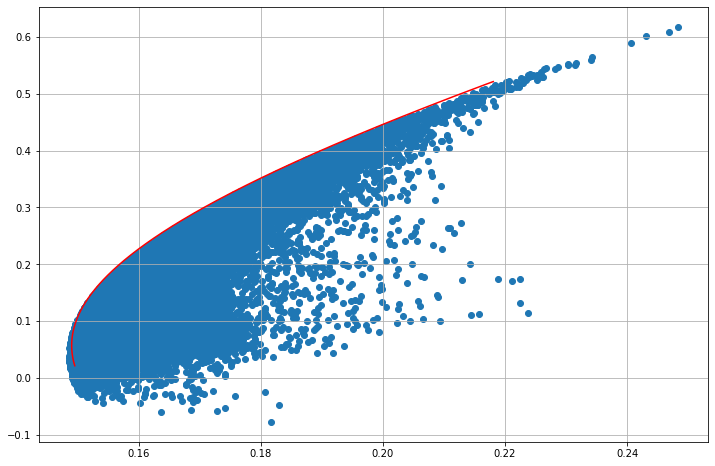

In [27]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(arr_volatility, arr_mu + Rf_mean, color="Red")

plt.scatter(x, y)
# a = np.linspace(0,0.2,100)
# plt.plot(a, 1.65*a + Rf_mean, color="red")
plt.savefig("Efficient Frontier.jpg")
plt.show()
